## Using the sample of disk galaxies created in red_disk_sample.ipynb, the fraction of red disks as a function of redshift will be measured, incorporating corrections from simulated FERENGI galaxies.

In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os
import seaborn as sns
sns.set_style("ticks")
from PIL import Image
import urllib, cStringIO
import random
import scipy.stats.distributions as dist

#function for getting galaxy images
def get_image_from_url(url):

    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 


Populating the interactive namespace from numpy and matplotlib


In [2]:
#load cut values from red_disk_sample: 
cuts=Table.read('../data/red_disk_cuts.fits')
cuts['p_features_cut']=0.3
cuts['p_edgeon_no_cut']=0.3
cuts['mag_cut']=-13
cuts['p_clumpy_no_cut']=0

In [3]:
cuts

p_features_cut,p_clumpy_no_cut,p_edgeon_no_cut,N_edgeon_cut,z_lower,z_upper,mag_cut
float64,float64,float64,float64,int64,float64,float64
0.3,0.0,0.3,10.0,0,1.0,-13.0


In [4]:
#load the data - #70,198 galaxies matched between COSMOS and UV
data=Table.read('../data/cosmos_uv_matched_catalog.fits')

#GZH vote fractions
p_features = 't01_smooth_or_features_a02_features_or_disk_weighted_fraction'
p_artifact = 't01_smooth_or_features_a03_star_or_artifact_weighted_fraction'
p_clumpy_no = 't12_clumpy_a02_no_weighted_fraction'
p_edgeon_no = 't02_edgeon_a02_no_weighted_fraction'
N_edgeon = 't02_edgeon_total_weight'
f_obv = 't05_bulge_prominence_a03_obvious_weighted_fraction'
f_dom = 't05_bulge_prominence_a04_dominant_weighted_fraction'
p_irregular = 't08_odd_feature_a04_irregular_weighted_fraction'
p_merger = 't08_odd_feature_a06_merger_weighted_fraction'
p_odd = 't06_odd_a01_yes_weighted_fraction'

#define disk sample (face-on, not irregular, not merging, in volume limit)
disks_1 = (data[p_features]>0.3) & (data[p_edgeon_no]>cuts['p_edgeon_no_cut']) & (data[N_edgeon]>=cuts['N_edgeon_cut']) & (data['MR']<cuts['mag_cut']) 
#elliptcals: low p_features, in volume limit 
ellipticals = (data[p_features]<=cuts['p_features_cut']) & (data['MR']<cuts['mag_cut']) & (data[p_artifact]<.5)

mergers = (data[p_odd]>0.5) & (data[p_merger]>0.5) & disks_1
irregulars = (data[p_odd]>0.5) & (data[p_irregular]>0.5) & disks_1

#define red sequence
red_sequence = (data['activity_type']==1)
blue_cloud = (data['activity_type']==0)

#parameters calculated using B&C models
a1 = [0.38,0.27,0.16,0.05]
a2 = [0.14,0.10,0.06,0.02]

disks = (disks_1 != (irregulars | mergers)) #final disk definition - excludes irregulars and active mergers !!

In [5]:
disks = (disks_1 != (irregulars | mergers))

In [12]:
z_edges=np.linspace(0.2,1.1,5)
z_centers = []
for i in range(0,len(z_edges)-1):
    z_centers.append((z_edges[i]+z_edges[i+1])/2)

z_edges,z_centers



(array([ 0.2  ,  0.425,  0.65 ,  0.875,  1.1  ]),
 [0.3125, 0.53750000000000009, 0.76250000000000007, 0.98750000000000004])

In [30]:
edges = [10.1,10.4,10.7,11,11.3]

mass_cut = (data['mass_med'] >= edges[0]) & (data['mass_med'] <= edges[-1])
z_lim = (data['Z_BEST'] >= z_edges[0]) & (data['Z_BEST'] <= z_edges[-1])

len(data[disks & mass_cut & z_lim ])+len(data[ellipticals & mass_cut & z_lim])


14663

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


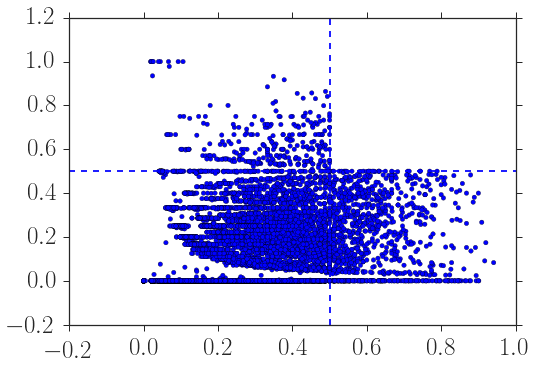

In [6]:
plt.scatter(data[disks][p_odd],data[disks][p_merger])
plt.axvline(.5,ls='dashed')
plt.axhline(.5,ls='dashed')

In [7]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

def equalbinning(x,nbin):
    #pick how many galaxies to be in each bin
    n, edges, patches = plt.hist(x, histedges_equalN(x, nbin))
    plt.close()
    centers = [np.mean([edges[i],edges[i+1]]) for i,b in enumerate(edges[0:len(edges)-1])]
    return edges,centers
def get_error(k,n,c=0.683):
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    return p_lower,p_upper

# Fraction 1: Red disks / (Red disks + Blue disks)

In [8]:
#define redshift bins
z_edges=np.linspace(0.2,1.1,5)
z_centers = []
for i in range(0,len(z_edges)-1):
    z_centers.append((z_edges[i]+z_edges[i+1])/2)

z_edges,z_centers

(array([ 0.2  ,  0.425,  0.65 ,  0.875,  1.1  ]),
 [0.3125, 0.53750000000000009, 0.76250000000000007, 0.98750000000000004])

10.1<M<10.4:
z=0.2:RD = 57.0, BD = 382.0
z=0.425:RD = 24.1, BD = 533.6
z=0.65:RD = 33.1, BD = 1071.9
z=0.875:RD = 8.8, BD = 1164.1
10.4<M<10.7:
z=0.2:RD = 67.0, BD = 337.0
z=0.425:RD = 48.3, BD = 474.6
z=0.65:RD = 101.1, BD = 919.3
z=0.875:RD = 70.2, BD = 985.7
10.7<M<11:
z=0.2:RD = 42.0, BD = 214.0
z=0.425:RD = 44.2, BD = 336.5
z=0.65:RD = 141.6, BD = 643.5
z=0.875:RD = 128.7, BD = 643.5
11<M<11.3:
z=0.2:RD = 20.0, BD = 69.0
z=0.425:RD = 34.9, BD = 119.3
z=0.65:RD = 99.3, BD = 253.7
z=0.875:RD = 114.1, BD = 266.2


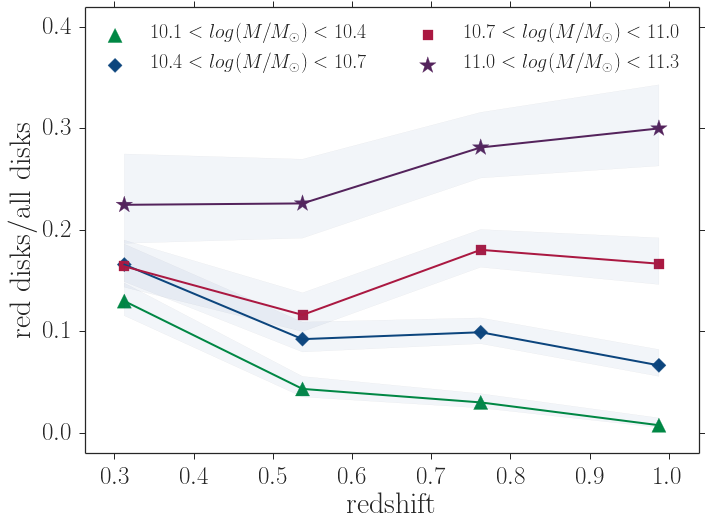

In [10]:
#edges,centers = equalbinning(data[(data['mass_med']>8) & disks]['mass_med'],4)
#edges = [9.9,10.6,11,11.7]
#edges = [9.9,10.3,10.7,11,11.4]
edges = [10.1,10.4,10.7,11,11.3]
colors = ['#008744','#0c457d','#aa1841','#54235c']
markers = ['^','D','s','*']
msizes = [200,100,100,300]
#masshist,edges = np.histogram(data[disks & (data['mass_med']>0)]['mass_med'],bins=4)
red_disk_fraction = {}
col='mass_med'

for mi in range(0,len(edges)-1):
    print '{}<M<{}:'.format(edges[mi],edges[mi+1])

    red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])]=[]
    red_disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])]=[]
    red_disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])]=[]

    mass_bin = (data[col]>edges[mi]) & (data[col]<=edges[mi+1])
    for i in range(0,len(z_edges)-1):
        z_bin = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
        red_disks = float(len(data[disks & z_bin & red_sequence & mass_bin ]))
        all_disks = len(data[disks & z_bin & mass_bin ])
        
        print 'z={}:RD = {:.1f}, BD = {:.1f}'.format(z_edges[i], red_disks/xi[i],(all_disks - red_disks)/xi[i])
        
        red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])].append(red_disks/all_disks if all_disks>0 else 0)
        err_lo,err_hi = get_error(red_disks,all_disks)
        red_disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])].append(err_hi)
        red_disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])].append(err_lo)

f=plt.figure(figsize=(11,8))
for i in range(0,len(edges)-1):
    plt.plot(z_centers,red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],color=colors[i],lw=2)
    plt.scatter(z_centers,red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],marker=markers[i],s=msizes[i],color=colors[i],label=r'${:.1f}<log(M/M_\odot)<{:.1f}$'.format(edges[i],edges[i+1]))
    plt.fill_between(z_centers,red_disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[i],edges[i+1])],red_disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[i],edges[i+1])],alpha=.07)
plt.xlim(z_centers[0]-.05,z_centers[-1]+.05)
plt.ylim(-.02,.42)
#plt.ylim(-.02,.3)
#plt.gca().invert_xaxis()
plt.xlabel(r'$\mathrm{redshift}$',fontsize = 30)
plt.ylabel(r'$\mathrm{red~disks/all~disks}$', fontsize=30)
plt.legend(fontsize=20,ncol=2)
#plt.savefig('../writeup/figures/red_disk_fraction1_mass_limited.pdf')

# Fraction 2: Disks in Red sequence / (all galaxies in red sequence)

## $\frac{red~disks \times \xi}{red~disks + red~ellipticals}$

In [9]:
slope = -0.89778586593873233
intercept = 1.228465271458902

xi = [z*slope + intercept for z in z_centers]
xi[0]=1
xi

[1, 0.74590536851683331, 0.54390354868061852, 0.34190172884440373]

10.1<M<10.4:
z=0.2:RD = 57.0, RE = 243.0
z=0.425:RD = 24.1, RE = 285.9
z=0.65:RD = 33.1, RE = 579.9
z=0.875:RD = 8.8, RE = 225.2
10.4<M<10.7:
z=0.2:RD = 67.0, RE = 237.0
z=0.425:RD = 48.3, RE = 303.7
z=0.65:RD = 101.1, RE = 836.9
z=0.875:RD = 70.2, RE = 514.8
10.7<M<11:
z=0.2:RD = 42.0, RE = 167.0
z=0.425:RD = 44.2, RE = 200.8
z=0.65:RD = 141.6, RE = 750.4
z=0.875:RD = 128.7, RE = 587.3
11<M<11.3:
z=0.2:RD = 20.0, RE = 106.0
z=0.425:RD = 34.9, RE = 124.1
z=0.65:RD = 99.3, RE = 365.7
z=0.875:RD = 114.1, RE = 310.9


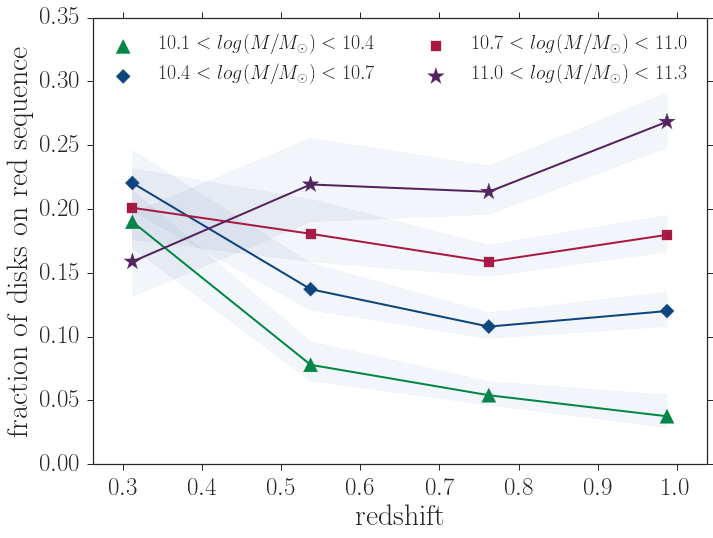

In [11]:
#edges,centers = equalbinning(data[(data['mass_med']>8) & disks]['mass_med'],3)
#edges = [9.9,10.3,10.7,11,11.4]
edges = [10.1,10.4,10.7,11,11.3]
#masshist,edges = np.histogram(data[disks & (data['mass_med']>0)]['mass_med'],bins=4)
disk_fraction = {}
col='mass_med'
for mi in range(0,len(edges)-1):
    print '{}<M<{}:'.format(edges[mi],edges[mi+1])
    
    disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])]=[]
    disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])]=[]
    disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])]=[]

    mass_bin = (data[col]>edges[mi]) & (data[col]<=edges[mi+1])
    for i in range(0,len(z_edges)-1):
        z_bin = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
        red_disks = float(len(data[disks & z_bin & red_sequence & mass_bin ]))*1/xi[i]
        all_red = len(data[red_sequence & z_bin & mass_bin ])
    
        print 'z={}:RD = {:.1f}, RE = {:.1f}'.format(z_edges[i], red_disks,all_red - red_disks)

        disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])].append(red_disks/all_red if all_red>0 else 0)
        err_lo,err_hi = get_error(red_disks,all_red)
        disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])].append(err_hi)
        disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])].append(err_lo)

f=plt.figure(figsize=(11,8))
for i in range(0,len(edges)-1):
    plt.plot(z_centers,disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],color=colors[i],lw=2)
    plt.scatter(z_centers,disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],marker=markers[i],s=msizes[i],color=colors[i],label=r'${:.1f}<log(M/M_\odot)<{:.1f}$'.format(edges[i],edges[i+1]))
    plt.fill_between(z_centers,disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[i],edges[i+1])],disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[i],edges[i+1])],alpha=.07)
plt.xlim(z_centers[0]-.05,z_centers[-1]+.05)
plt.xlabel(r'$\mathrm{redshift}$',fontsize = 30)
plt.ylabel(r'$\mathrm{fraction~of~disks~on~red~sequence}$', fontsize=30)
plt.legend(fontsize=20,ncol=2)
#plt.savefig('../writeup/figures/red_disk_fraction2_mass_limited.pdf')

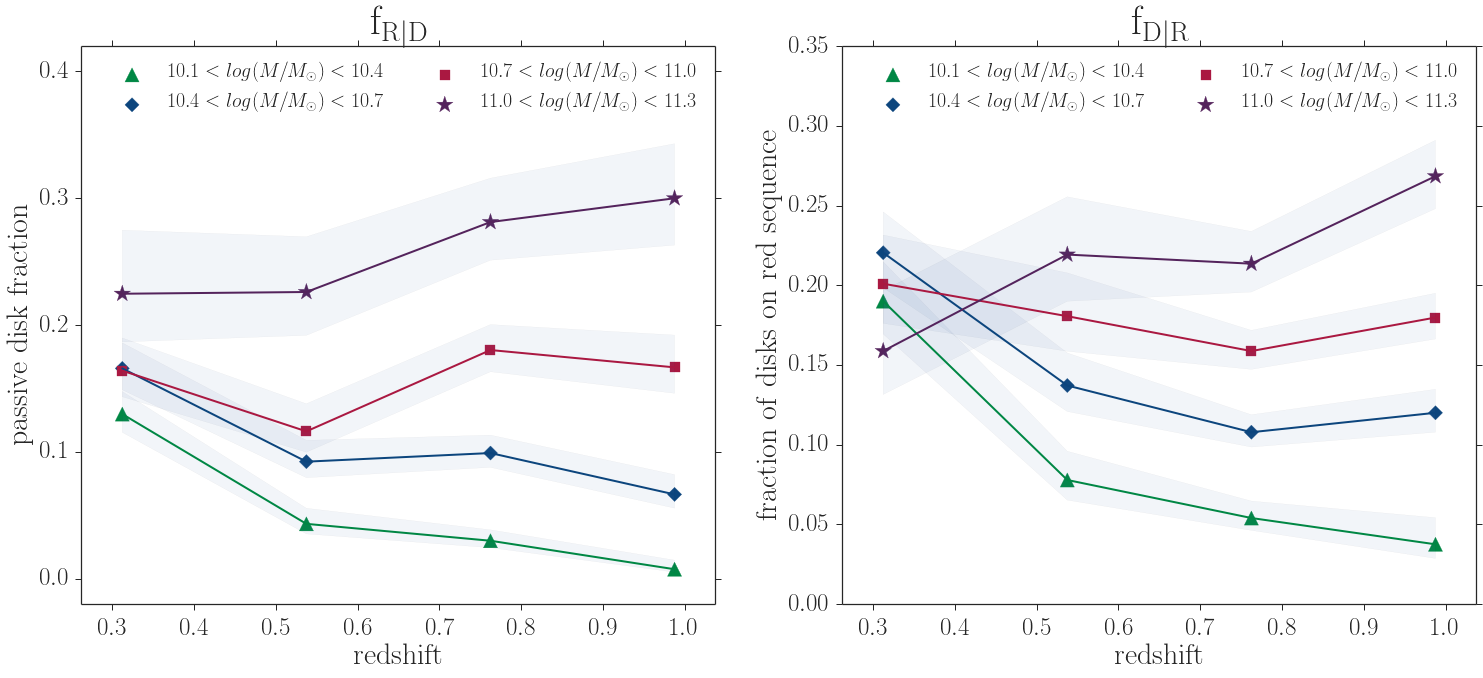

In [12]:
f=plt.figure(figsize=(25,10))
gs=gridspec.GridSpec(1,2)
ax=plt.subplot(gs[0,1])
#edges = [9.9,10.3,10.7,11,11.4]
edges = [9.8,10.1,10.4,10.7,11,11.3]
colors = ['k','#008744','#0c457d','#aa1841','#54235c']
markers = ['o','^','D','s','*']
msizes = [100,200,100,100,300]

#masshist,edges = np.histogram(data[disks & (data['mass_med']>0)]['mass_med'],bins=4)
disk_fraction = {}
col='mass_med'
for mi in range(1,len(edges)-1):
    disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])]=[]
    disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])]=[]
    disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])]=[]

    mass_bin = (data[col]>edges[mi]) & (data[col]<=edges[mi+1])
    for i in range(0,len(z_edges)-1):
        z_bin = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
        red_disks = float(len(data[disks & z_bin & red_sequence & mass_bin ]))*1/xi[i]
        all_red = len(data[red_sequence & z_bin & mass_bin ])
        disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])].append(red_disks/all_red if all_red>0 else 0)
        err_lo,err_hi = get_error(red_disks,all_red)
        disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])].append(err_hi)
        disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])].append(err_lo)

for i in range(1,len(edges)-1):
    plt.plot(z_centers,disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],color=colors[i],lw=2)
    plt.scatter(z_centers,disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],marker=markers[i],s=msizes[i],color=colors[i],label=r'${:.1f}<log(M/M_\odot)<{:.1f}$'.format(edges[i],edges[i+1]))
    plt.fill_between(z_centers,disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[i],edges[i+1])],disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[i],edges[i+1])],alpha=.07)
plt.xlim(z_centers[0]-.05,z_centers[-1]+.05)
plt.xlabel(r'$\mathrm{redshift}$',fontsize = 30)
plt.ylabel(r'$\mathrm{fraction~of~disks~on~red~sequence}$', fontsize=30)
plt.title(r'$\mathrm{f_{D|R}}$', fontsize=40)
plt.legend(fontsize=20,ncol=2)

ax = plt.subplot(gs[0,0])

#masshist,edges = np.histogram(data[disks & (data['mass_med']>0)]['mass_med'],bins=4)
red_disk_fraction = {}
col='mass_med'

for mi in range(1,len(edges)-1):
    red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])]=[]
    red_disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])]=[]
    red_disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])]=[]

    mass_bin = (data[col]>edges[mi]) & (data[col]<=edges[mi+1])
    for i in range(0,len(z_edges)-1):
        z_bin = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
        red_disks = float(len(data[disks & z_bin & red_sequence & mass_bin ]))
        all_disks = len(data[disks & z_bin & mass_bin ])
        red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[mi],edges[mi+1])].append(red_disks/all_disks if all_disks>0 else 0)
        err_lo,err_hi = get_error(red_disks,all_disks)
        red_disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[mi],edges[mi+1])].append(err_hi)
        red_disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[mi],edges[mi+1])].append(err_lo)

for i in range(1,len(edges)-1):
    plt.plot(z_centers,red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],color=colors[i],lw=2)
    plt.scatter(z_centers,red_disk_fraction['{:.2f}_to_{:.2f}'.format(edges[i],edges[i+1])],marker=markers[i],s=msizes[i],color=colors[i],label=r'${:.1f}<log(M/M_\odot)<{:.1f}$'.format(edges[i],edges[i+1]))
    plt.fill_between(z_centers,red_disk_fraction['{:.2f}_to_{:.2f}_hi'.format(edges[i],edges[i+1])],red_disk_fraction['{:.2f}_to_{:.2f}_lo'.format(edges[i],edges[i+1])],alpha=.07)
plt.xlim(z_centers[0]-.05,z_centers[-1]+.05)
plt.ylim(-.02,.42)
#plt.gca().invert_xaxis()
plt.xlabel(r'$\mathrm{redshift}$',fontsize = 30)
plt.ylabel(r'$\mathrm{passive~disk~fraction}$', fontsize=30)
plt.title(r'$\mathrm{f_{R|D}}$', fontsize=40)
plt.legend(fontsize=20,ncol=2)
#plt.savefig('../writeup/figures/red_disk_fraction_mass_limited.pdf')

Create table of fractions and errors at each redshift to use in model

In [13]:
import pickle

In [14]:
#edges = edges[1:]
z_centers = [round(zc,2) for zc in z_centers]
m_centers = [(edges[i]+edges[i+1])/2. for i in range(0,len(edges)-1)]
z_centers,m_centers

([0.31, 0.54, 0.76, 0.99], [9.95, 10.25, 10.55, 10.85, 11.15])

In [15]:
results={}
results['z_centers']=z_centers
results['m_centers']=m_centers
for mi in range(0,len(edges)-1):
    m_center = (edges[mi]+edges[mi+1])/2.
    results['M={:.2f}'.format(m_center)]={}
    results['M={:.2f}'.format(m_center)]['N_BD']=[]
    results['M={:.2f}'.format(m_center)]['N_RD']=[]
    results['M={:.2f}'.format(m_center)]['N_RE']=[]
    results['M={:.2f}'.format(m_center)]['f_RID']=[]
    results['M={:.2f}'.format(m_center)]['f_RID_err']=[]
    results['M={:.2f}'.format(m_center)]['f_DIR']=[]
    results['M={:.2f}'.format(m_center)]['f_DIR_err']=[]
    mass_bin = (data[col]>edges[mi]) & (data[col]<=edges[mi+1])
    for i in range(0,len(z_edges)-1):
        z_bin = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
        
        red_disks = float(len(data[disks & z_bin & red_sequence & mass_bin ]))/xi[i]
        all_disks = len(data[disks & z_bin & mass_bin ])
        blue_disks = all_disks/xi[i] - red_disks
        all_red = len(data[red_sequence & z_bin & mass_bin ])
        RE = all_red-red_disks

        results['M={:.2f}'.format(m_center)]['N_BD'].append(blue_disks)
        results['M={:.2f}'.format(m_center)]['N_RD'].append(red_disks)
        results['M={:.2f}'.format(m_center)]['N_RE'].append(RE)
        
        f_rid = red_disks/(red_disks + blue_disks) if all_red>0 else 0
        f_dir = red_disks/(red_disks + RE) if all_disks>0 else 0

        results['M={:.2f}'.format(m_center)]['f_RID'].append(f_rid)
        results['M={:.2f}'.format(m_center)]['f_DIR'].append(f_dir)

        err_lo,err_hi = get_error(red_disks,red_disks + blue_disks)
        err = (err_hi-err_lo)/2.
        results['M={:.2f}'.format(m_center)]['f_RID_err'].append(err)
        
        err_lo,err_hi = get_error(red_disks,red_disks + RE)
        err = (err_hi-err_lo)/2.
        results['M={:.2f}'.format(m_center)]['f_DIR_err'].append(err)


In [16]:
results

{'M=10.25': {'N_BD': [382.0,
   533.57974992375739,
   1071.8812212463408,
   1164.0771789753835],
  'N_RD': [57.0, 24.131747483989027, 33.094102885821847, 8.7744510978043984],
  'N_RE': [243.0, 285.86825251601095, 579.90589711417817, 225.22554890219561],
  'f_DIR': [0.19,
   0.077844346722545255,
   0.053987117268877401,
   0.037497654264121362],
  'f_DIR_err': [0.022651054733687587,
   0.01533847313420892,
   0.0091954907057087767,
   0.012783417478851184],
  'f_RID': [0.12984054669703873,
   0.043269230769230775,
   0.029950083194675542,
   0.0074812967581047388],
  'f_RID_err': [0.016075005865260603,
   0.0087084185353707676,
   0.0051731097850472828,
   0.0026075101517676856]},
 'M=10.55': {'N_BD': [337.0,
   474.59103385178418,
   919.28063571727341,
   985.66333998669404],
  'N_RD': [67.0, 48.263494967978055, 101.12086992890008, 70.195608782435187],
  'N_RE': [237.0, 303.73650503202197, 836.87913007109989, 514.80439121756478],
  'f_DIR': [0.22039473684210525,
   0.13711220161357

In [17]:
import pickle
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [5]:
import pickle
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)


In [14]:
m_centers=results['m_centers']
for m in m_centers[1:]:
    print m, np.sum(results['M={}'.format(m)]['N_RD']) + np.sum(results['M={}'.format(m)]['N_BD']) + np.sum(results['M={}'.format(m)]['N_RE'])

10.25 4608.53815015
10.55 4895.53500956
10.85 3899.46000431
11.15 1883.19789021


In [15]:
4**25

1125899906842624

In [16]:
25**4

390625